# Mapping LSOA results

## Proportions of stroke types: Analysis of SAMueL data

## Import packages

In [1]:
# import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo  # to make catchment area geometry

pd.set_option('display.max_rows', 150)

In [2]:
dir_output = 'output'
limit_to_england = False

## Load data

### Load shape file

In [3]:
lsoa_gdf = stroke_maps.load_data.lsoa_geography()
lsoa_gdf = lsoa_gdf.to_crs('EPSG:27700')

lsoa_gdf.head(3)

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.642 181906.500, 532248.262 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.826 181786.896, 532248.262 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.080 182068.426, 532419.605 18..."


In [4]:
# Load country outline
# outline = geopandas.read_file('./data/Countries_(December_2022)_GB_BFC.zip')
if limit_to_england:
    # mask = outline['CTRY22NM'] == 'England'
    # outline = outline[mask]
    outline = stroke_maps.load_data.england_outline()
else:
    # mask = (outline['CTRY22NM'] == 'England') | (outline['CTRY22NM'] == 'Wales')
    # outline = outline[mask]
    outline = stroke_maps.load_data.englandwales_outline()

In [5]:
outline

,country,OBJECTID,ctry11cd,ctry11cdo,ctry11nm,ctry11nmw,GlobalID,geometry
0,0,1,E92000001,921,England,Lloegr,27bbf7ca-99bd-4fe8-87a1-d498d48e3084,"MULTIPOLYGON (((83994.599 5397.099, 84001.300 ..."


### Load hospital info

Load in the stroke unit coordinates and merge in the services information:

In [6]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

df_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1
use_msu,0,1,1
transfer_unit_postcode,nearest,nearest,nearest
lsoa,Ceredigion 002A,Cambridge 013D,Liverpool 005A
lsoa_code,W01000512,E01017995,E01006654
region,Hywel Dda University Health Board,NHS Cambridgeshire and Peterborough ICB - 06H,NHS Cheshire and Merseyside ICB - 99A


In [7]:
hospitals_gdf = stroke_maps.load_data.stroke_unit_coordinates()
hospitals_gdf = pd.merge(
    hospitals_gdf, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

In [8]:
hospitals_gdf.head(3)

,BNG_E,BNG_N,Latitude,Longitude,geometry,use_ivt,use_mt
postcode,,,,,,,
SY231ER,259208,281805,52.416068,-4.071578,POINT (259208.000 281805.000),1,0
CB20QQ,546375,254988,52.173741,0.139114,POINT (546375.000 254988.000),1,1
L97AL,338020,397205,53.467918,-2.935131,POINT (338020.000 397205.000),1,1


### Load LSOA model output data

In [9]:
lsoa_data = pd.read_csv(os.path.join(dir_output, 'cohort_outcomes_weighted.csv'))
lsoa_data.head(3).T

,0,1,2
lsoa,Adur 001A,Adur 001B,Adur 001C
closest_ivt_time,17.6,18.7,17.6
closest_ivt_unit,BN25BE,BN25BE,BN112DH
closest_mt_time,17.6,18.7,19.8
closest_mt_unit,BN25BE,BN25BE,BN25BE
transfer_mt_time,0.0,0.0,31.6
transfer_mt_unit,BN25BE,BN25BE,BN25BE
mt_transfer_required,False,False,True
ivt_drip_ship,107.6,108.7,107.6
mt_drip_ship,167.6,168.7,259.2


In [10]:
# Merge with shape file

lsoa_data_gdf = lsoa_gdf.merge(lsoa_data, left_on='LSOA11NM', right_on='lsoa', how='right')
lsoa_data_gdf.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,...,mothership_weighted_mrs_shift,mothership_weighted_added_mrs_less_equal_2,drip_ship_weighted_treated_added_utility,drip_ship_weighted_treated_mrs_less_equal_2,drip_ship_weighted_treated_mrs_shift,drip_ship_weighted_treated_added_mrs_less_equal_2,mothership_weighted_treated_added_utility,mothership_weighted_treated_mrs_less_equal_2,mothership_weighted_treated_mrs_shift,mothership_weighted_treated_added_mrs_less_equal_2
0,30557.0,E01031349,Adur 001A,Adur 001A,524915.0,105607.0,-0.22737,50.83651,3.641032e+05,3054.751704,...,-0.178152,0.036258,0.136330,0.566888,-0.715921,0.145707,0.136330,0.566888,-0.715921,0.145707
1,30558.0,E01031350,Adur 001B,Adur 001B,524825.0,106265.0,-0.22842,50.84244,2.921732e+05,2977.102897,...,-0.177400,0.036112,0.135791,0.566301,-0.712902,0.145120,0.135791,0.566301,-0.712902,0.145120
2,30559.0,E01031351,Adur 001C,Adur 001C,523053.0,108004.0,-0.25300,50.85845,5.281768e+06,11671.349143,...,-0.176649,0.035966,0.111059,0.539792,-0.580860,0.118610,0.135251,0.565714,-0.709882,0.144533
3,30560.0,E01031352,Adur 001D,Adur 001D,524141.0,106299.0,-0.23812,50.84290,2.452292e+05,2134.908586,...,-0.176649,0.035966,0.111059,0.539792,-0.580860,0.118610,0.135251,0.565714,-0.709882,0.144533
4,30578.0,E01031370,Adur 001E,Adur 001E,523561.0,105916.0,-0.24649,50.83958,2.402445e+05,2447.096939,...,-0.176649,0.035966,0.111591,0.540364,-0.583788,0.119183,0.135251,0.565714,-0.709882,0.144533


In [11]:
cols = [c for c in lsoa_data_gdf.columns if (('lvo' in c) & ('nlvo' not in c) & ('utility' in c))]

lsoa_data_gdf[cols].head(10).T

,0,1,2,3,4,5,6,7,8,9
drip_ship_lvo_ivt_added_utility,0.058718,0.058412,0.058718,0.058718,0.059024,0.058718,0.058718,0.058718,0.058718,0.058718
drip_ship_lvo_ivt_mt_added_utility,0.163611,0.162952,0.109278,0.109278,0.109921,0.109278,0.109278,0.109278,0.109278,0.109278
drip_ship_lvo_mt_added_utility,0.163611,0.162952,0.109278,0.109278,0.109921,0.109278,0.109278,0.109278,0.109278,0.109278
mothership_lvo_ivt_added_utility,0.058718,0.058412,0.058107,0.058107,0.058107,0.058412,0.057829,0.057524,0.057524,0.057524
mothership_lvo_ivt_mt_added_utility,0.163611,0.162952,0.162292,0.162292,0.162292,0.162952,0.161693,0.161033,0.161033,0.161033
mothership_lvo_mt_added_utility,0.163611,0.162952,0.162292,0.162292,0.162292,0.162952,0.161693,0.161033,0.161033,0.161033
drip_ship_lvo_mix_added_utility,0.155483,0.154851,0.105360,0.105360,0.105977,0.105360,0.105360,0.105360,0.105360,0.105360
mothership_lvo_mix_added_utility,0.155483,0.154851,0.154219,0.154219,0.154219,0.154851,0.153644,0.153012,0.153012,0.153012


Patient proportions:

In [12]:
patient_proportions = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [13]:
patient_proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

In [14]:
# Proportion of treated ischaemic patients:
prop_ischaemic_treated = 0.0

for key, value in patient_proportions.items():
    if (('lvo' in key) & ('no_treat' not in key)):
        print(key)
        prop_ischaemic_treated += value

prop_ischaemic_treated

lvo_ivt_only
lvo_ivt_mt
lvo_mt_only
nlvo_ivt


0.21500000000000002

In [15]:
prop_nlvo_of_treated = patient_proportions['nlvo_ivt'] / prop_ischaemic_treated
prop_lvo_of_treated = 1.0 - prop_nlvo_of_treated

prop_nlvo_of_treated, prop_lvo_of_treated

(0.49581395348837204, 0.5041860465116279)

## Calculate difference between Mothership and Drip and Ship

In [16]:
cohort_names = ['nlvo_ivt', 'lvo_mix', 'weighted_treated']

outcome_names = ['added_utility', 'added_mrs_less_equal_2', 'mrs_shift']

In [17]:
cols_diff = [f'{c}_{o}_mothership_minus_dripship' for c in cohort_names for o in outcome_names]
cols_moth = [f'mothership_{c}_{o}' for c in cohort_names for o in outcome_names]
cols_drip = [f'drip_ship_{c}_{o}' for c in cohort_names for o in outcome_names]

lsoa_data_gdf[cols_diff] = lsoa_data_gdf[cols_moth].values - lsoa_data_gdf[cols_drip].values

## Map outliers

Make a new dataframe with only a subset of the full data:

In [41]:
data_field = 'added_utility'

cols = [
    f'nlvo_ivt_{data_field}_mothership_minus_dripship',
    f'lvo_mix_{data_field}_mothership_minus_dripship',
    f'weighted_treated_{data_field}_mothership_minus_dripship',
]

In [19]:
gdf_outliers = lsoa_data_gdf[['geometry'] + cols]

Find outliers separately for each case because the outlying condition is different each time.

For nLVO, most of the map has negative mothership minus drip-and-ship added utility, so pick out values that are positive.

For the LVO and ischaemic mix, most of the map is positive so pick out any negative values.

In [45]:
col = cols[0]
gdf_outliers[f'outlier_{col}'] = gdf_outliers[col] > 0.0

# How many values are outliers?
print(len(gdf_outliers.loc[gdf_outliers[f'outlier_{col}'] == True]))

0


In [46]:
col = cols[1]
gdf_outliers[f'outlier_{col}'] = gdf_outliers[col] < 0.0

# How many values are outliers?
print(len(gdf_outliers.loc[gdf_outliers[f'outlier_{col}'] == True]))

0


In [47]:
col = cols[2]
gdf_outliers[f'outlier_{col}'] = gdf_outliers[col] < 0.0

# How many values are outliers?
print(len(gdf_outliers.loc[gdf_outliers[f'outlier_{col}'] == True]))

266


Only the mixed population has outliers. Plot their locations:

266


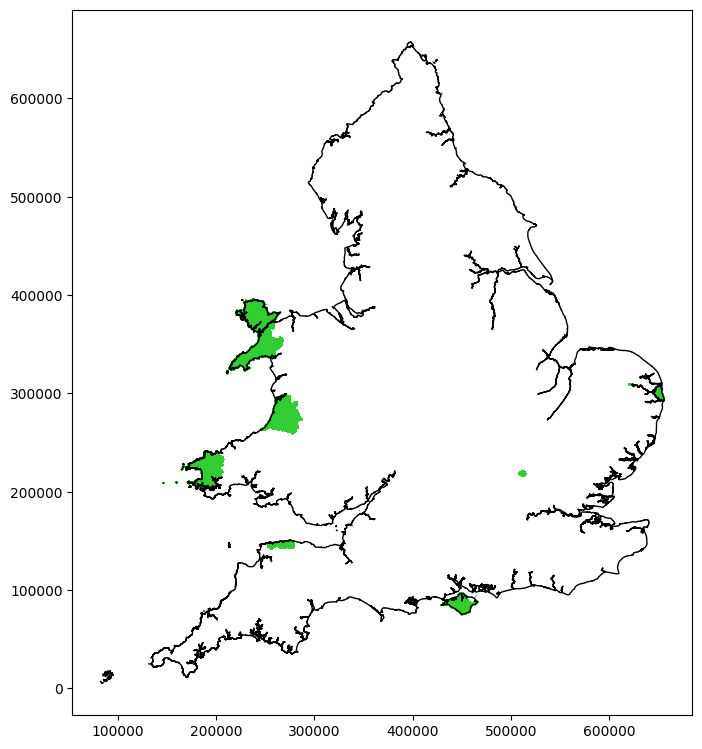

In [49]:
col = cols[2]

# Plot data
fig, ax = plt.subplots(figsize=(8, 10))
mask = gdf_outliers[f'outlier_{col}'] == True
print(len(gdf_outliers.loc[mask]))
gdf_outliers.loc[mask].plot(
    ax=ax, # Set which axes to use for plot (only one here)
    color='LimeGreen', # Column to apply colour
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
)
# Add country border
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
plt.show()

## Check outlier times

Make a smaller dataframe of all of the columns for just these outlier areas:

In [24]:
col = cols[2]

mask = gdf_outliers[f'outlier_{col}'] == True

gdf_out_adv = lsoa_data_gdf.loc[mask].copy()

In [25]:
gdf_out_adv

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,...,mothership_weighted_treated_added_mrs_less_equal_2,nlvo_ivt_added_utility_mothership_minus_dripship,nlvo_ivt_added_mrs_less_equal_2_mothership_minus_dripship,nlvo_ivt_mrs_shift_mothership_minus_dripship,lvo_mix_added_utility_mothership_minus_dripship,lvo_mix_added_mrs_less_equal_2_mothership_minus_dripship,lvo_mix_mrs_shift_mothership_minus_dripship,weighted_treated_added_utility_mothership_minus_dripship,weighted_treated_added_mrs_less_equal_2_mothership_minus_dripship,weighted_treated_mrs_shift_mothership_minus_dripship
6195,17053.0,E01017564,Central Bedfordshire 033D,Central Bedfordshire 033D,511088.0,218265.0,-0.388520,51.85194,1.794032e+07,20786.770830,...,0.105991,-0.029307,-0.032100,0.168373,0.017787,0.018879,-0.093372,-0.005563,-0.006397,0.036405
6196,33344.0,W01000523,Ceredigion 001C,Ceredigion 001C,268865.0,290703.0,-3.933180,52.49843,1.294319e+08,55283.856672,...,0.083501,-0.049971,-0.054607,0.285116,0.032012,0.031838,-0.151030,-0.008636,-0.011022,0.065217
6197,33367.0,W01000548,Ceredigion 001D,Ceredigion 001D,261295.0,285094.0,-4.042280,52.44616,1.452597e+07,21925.550573,...,0.083501,-0.052551,-0.057443,0.300184,0.029981,0.029714,-0.140043,-0.010940,-0.013500,0.078228
6198,33368.0,W01000549,Ceredigion 001E,Ceredigion 001E,267387.0,283780.0,-3.952180,52.43587,2.582152e+07,27673.339921,...,0.082912,-0.052200,-0.057050,0.298004,0.030038,0.029769,-0.140460,-0.010737,-0.013277,0.076937
6199,34732.0,W01001937,Ceredigion 001F,Ceredigion 001F,261990.0,288178.0,-4.033340,52.47405,2.536853e+07,28049.044543,...,0.082912,-0.049574,-0.054163,0.282681,0.032098,0.031924,-0.151601,-0.008396,-0.010759,0.063722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32026,29482.0,E01030263,Waveney 005B,Waveney 005B,653306.0,293630.0,1.729125,52.48177,7.875654e+05,3912.339748,...,0.095573,-0.040373,-0.044184,0.231375,0.035260,0.036979,-0.183378,-0.002240,-0.003263,0.022262
32027,29489.0,E01030270,Waveney 005C,Waveney 005C,652508.0,293295.0,1.717146,52.47913,5.150318e+05,3402.978540,...,0.096754,-0.039406,-0.043130,0.225922,0.036493,0.038286,-0.189868,-0.001139,-0.002081,0.016286
32032,29487.0,E01030268,Waveney 006C,Waveney 006C,651334.0,293510.0,1.700058,52.48160,3.534155e+05,4242.495260,...,0.095573,-0.039969,-0.043739,0.229017,0.035805,0.037544,-0.186202,-0.001765,-0.002758,0.019669
32033,29488.0,E01030269,Waveney 006D,Waveney 006D,651416.0,293083.0,1.700941,52.47773,8.158435e+05,4654.804663,...,0.096163,-0.039040,-0.042723,0.223694,0.037020,0.038818,-0.192550,-0.000691,-0.001611,0.013829


Pick out the first part of the LSOA names to get an idea of their towns or regions:

In [32]:
sorted(list(set([s[:-5] for s in gdf_out_adv['LSOA11NM'].values])))

['Central Bedfordshire',
 'Ceredigion',
 'Great Yarmouth',
 'Gwynedd',
 'Isle of Anglesey',
 'Isle of Wight',
 'North Devon',
 'Norwich',
 'Pembrokeshire',
 'Waveney']

Eyeball the travel and treatment time columns:

In [26]:
cols_to_check = [
    'LSOA11NM',
    'closest_ivt_time',
    'closest_ivt_unit',
    'closest_mt_time',
    'closest_mt_unit',
    'transfer_mt_time',
    'transfer_mt_unit',
    'mt_transfer_required',
    'ivt_drip_ship',
    'mt_drip_ship',
    'ivt_mothership',
    'mt_mothership'
]


In [27]:
gdf_out_adv[cols_to_check].T

,6195,6196,6197,6198,6199,6200,6201,6202,6203,6204,...,32021,32022,32023,32024,32025,32026,32027,32032,32033,32035
LSOA11NM,Central Bedfordshire 033D,Ceredigion 001C,Ceredigion 001D,Ceredigion 001E,Ceredigion 001F,Ceredigion 002A,Ceredigion 002B,Ceredigion 002D,Ceredigion 002F,Ceredigion 003A,...,Waveney 004C,Waveney 004D,Waveney 004E,Waveney 004F,Waveney 005A,Waveney 005B,Waveney 005C,Waveney 006C,Waveney 006D,Waveney 007A
closest_ivt_time,21.9,16.5,10.1,12.2,18.7,6.9,6.9,7.9,6.9,9.0,...,17.6,17.6,16.5,17.6,18.7,15.5,15.5,16.5,17.6,16.5
closest_ivt_unit,LU40DZ,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,SY231ER,...,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA,NR316LA
closest_mt_time,91.7,133.6,133.6,134.7,134.7,134.7,135.8,136.8,134.7,136.8,...,111.1,111.1,112.1,111.1,110.0,111.1,108.9,111.1,110.0,111.1
closest_mt_unit,NW12BU,ST46QG,CF144XW,CF144XW,ST46QG,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,...,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ
transfer_mt_time,45.5,135.8,135.8,135.8,135.8,135.8,135.8,135.8,135.8,135.8,...,105.7,105.7,105.7,105.7,105.7,105.7,105.7,105.7,105.7,105.7
transfer_mt_unit,NW12BU,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,CF144XW,...,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ,CB20QQ
mt_transfer_required,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
ivt_drip_ship,111.9,106.5,100.1,102.2,108.7,96.9,96.9,97.9,96.9,99.0,...,107.6,107.6,106.5,107.6,108.7,105.5,105.5,106.5,107.6,106.5
mt_drip_ship,277.4,362.3,355.9,358.0,364.5,352.7,352.7,353.7,352.7,354.8,...,333.3,333.3,332.2,333.3,334.4,331.2,331.2,332.2,333.3,332.2


Find the difference in travel times between LSOA to MT unit and LSOA to IVT unit.

In [33]:
gdf_out_adv['unit_time_diff'] = gdf_out_adv['closest_mt_time'] - gdf_out_adv['closest_ivt_time']

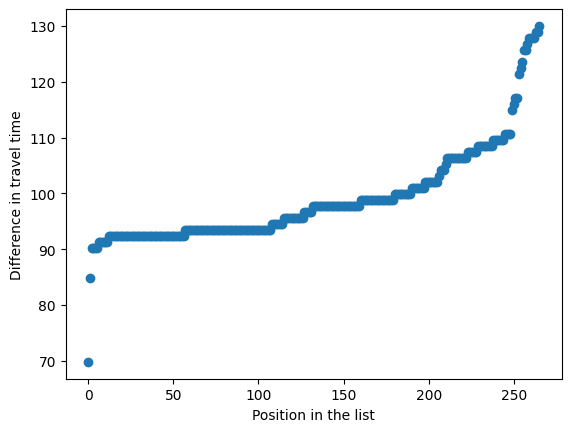

In [53]:
plt.scatter(np.arange(len(gdf_out_adv)), sorted(gdf_out_adv['unit_time_diff']))
plt.xlabel('Position in the list')
plt.ylabel('Difference in travel time')
plt.show()

Eyeballing this, nearly all of the outliers have a difference in time of at least 90 minutes or an hour and a half.

The shortest time is for Central Bedfordshire, which is anomalous in the travel times matrix because none of its surrounding LSOAs have similar travel times. This LSOA has a longer time direct to the MT unit (91.7 mins) than the sum of the travel time to the IVT unit and then transfer to the MT unit (21.9 + 45.5 = 67.4 mins).

Find the shortest time excluding that LSOA:

In [34]:
mask_bed = gdf_out_adv['LSOA11NM'].str.contains('Bedfordshire')

In [35]:
gdf_out_adv.loc[~mask_bed, 'unit_time_diff'].min()

84.80000000000001

## Pick out LSOAs similar to the outliers

Find if there are other LSOAs in the full dataframe that are not flagged as outliers but have a similar difference in unit travel times.

In [36]:
lsoa_data_gdf['unit_time_diff'] = lsoa_data_gdf['closest_mt_time'] - lsoa_data_gdf['closest_ivt_time']

In [37]:
mask_time = lsoa_data_gdf['unit_time_diff'] >= 84.8

In [38]:
len(lsoa_data_gdf.loc[mask_time])

359

There are more LSOAs in this list than there were in the outliers list.

Plot the new flagged LSOAs next to the marked outliers:

266


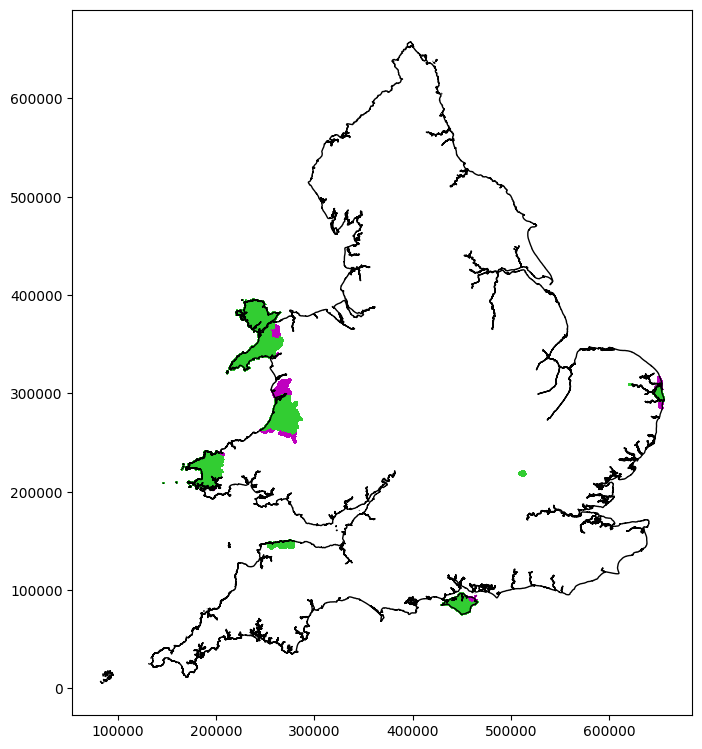

In [54]:
# Plot data
fig, ax = plt.subplots(figsize=(8, 10))

lsoa_data_gdf.loc[mask_time].plot(
    ax=ax, # Set which axes to use for plot (only one here)
    color='magenta',
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
)

mask = gdf_outliers[f'outlier_{col}'] == True
print(len(gdf_outliers.loc[mask]))
gdf_outliers.loc[mask].plot(
    ax=ax, # Set which axes to use for plot (only one here)
    color='LimeGreen',
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
)

# Add country border
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)
plt.show()